# Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Предстоит построить модель, которая предскажет температуру стали.

## Обзор данных

In [1]:
# импорт необходимых библиотек

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

In [2]:
# создание датафрейма
try:
    df_arc = pd.read_csv('/datasets/data_arc_new.csv')
    df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    df_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    df_gas = pd.read_csv('/datasets/data_gas_new.csv')
    df_temp = pd.read_csv('/datasets/data_temp_new.csv')
    df_wire = pd.read_csv('/datasets/data_wire_new.csv')
    df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    df_arc = pd.read_csv('data_arc_new.csv')
    df_bulk = pd.read_csv('data_bulk_new.csv')
    df_bulk_time = pd.read_csv('data_bulk_time_new.csv')
    df_gas = pd.read_csv('data_gas_new.csv')
    df_temp = pd.read_csv('data_temp_new.csv')
    df_wire = pd.read_csv('data_wire_new.csv')
    df_wire_time = pd.read_csv('data_wire_time_new.csv')

### Ознакомление с данными

#### Данные от электродах

In [3]:
# данные об электродах
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [4]:
df_arc.duplicated().sum()

0

Пропусков в данных нет, полных дубликатов строк тоже нет.

In [5]:
#ознакомимся с датафреймом
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


In [6]:
df_arc['Активная мощность'].describe()

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64

In [7]:
df_arc['Реактивная мощность'].describe()

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64

В данных о мощности выделены активная составляющая (полезная мощность, идущая на нагрева расплава) и реактивная (потери), видно, что величина полезной мощности сопоставима с потерями. Отрицательные значения реактивной мощности являются необъяснимыми, видимо это выбросы.Для определения величины затраченной энергии необходимо умножить мощность на длительность нагрева.

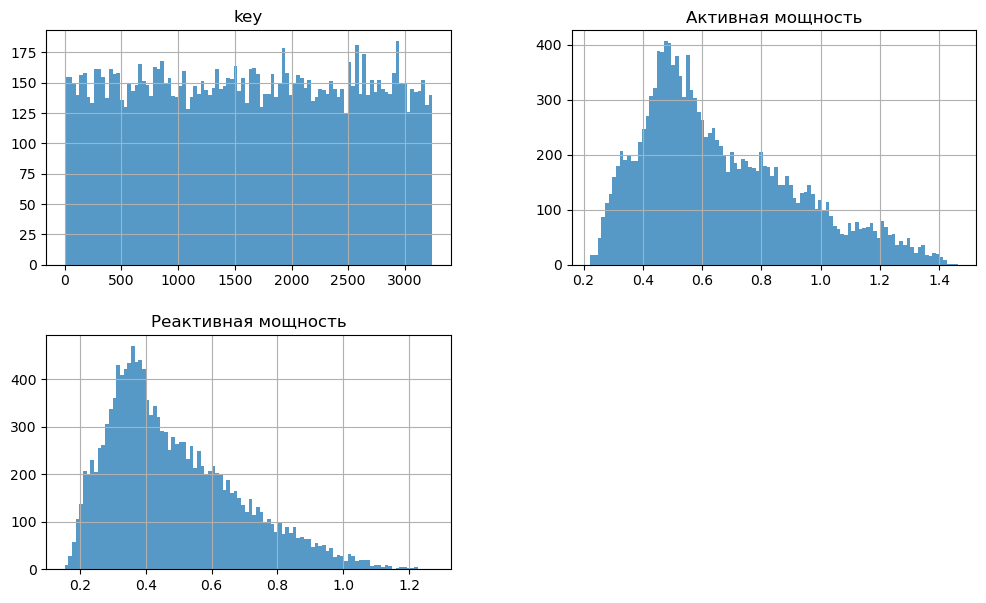

In [8]:
# посмотрим распределение
df_arc[df_arc['Реактивная мощность'] > 0].hist(bins=100, legend=False, alpha=0.75,figsize=(12,7));

Распределение мощностей имеет вид нормального со сдвигом вправо.

In [9]:
# определим, для скольких партий представлены данные
df_arc['key'].nunique()

3214

In [10]:
# определим количество циклов нагрева для каждой партии
df_arc['key'].value_counts()

2108    16
1513    15
1689    15
2567    14
46      13
        ..
112      1
2472     1
2025     1
3059     1
1615     1
Name: key, Length: 3214, dtype: int64

Данные представлены для 3214 партий расплава, количество циклов нагрева варьируется от 1 до 16.

#### Данные о засыпке из бункера

In [11]:
# данные о засыпке
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [12]:
df_bulk.duplicated().sum()

0

Дубликатов нет.

In [13]:
df_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


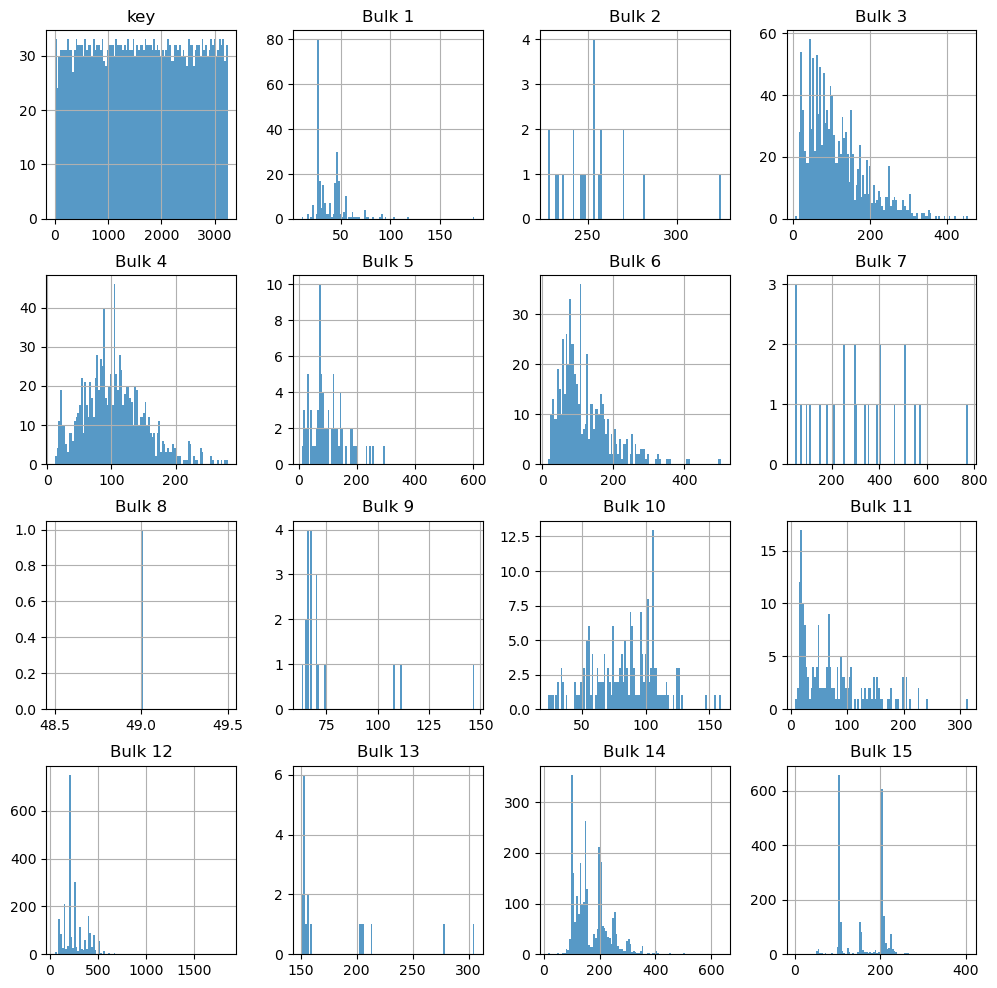

In [14]:
# посмотрим распределение
df_bulk.hist(bins=100, legend=False, alpha=0.75,figsize=(12,12));

Видимо, существует 15 контейнеров с легирующей крошкой. Для каждой партии указано количество той или иной крошки, использованной  при выплавке металла.

In [15]:
# определим, для скольких партий представлены данные
df_bulk['key'].nunique()

3129

In [16]:
# максимальное количество записей для каждой партии
df_bulk['key'].value_counts().max()

1

Данные для 3129 партий, для каждой партии существует только одна запись. Данные о нагреве содержали 3214 партий, существуют различия в датафреймах для номеров партий.

In [17]:
# информация о времени засыпки
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [18]:
# информация о времени засыпки
df_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34


#### Данные о проволочных материалах

In [19]:
# информация о датафрейме
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [20]:
# проверим дубликаты
df_wire.duplicated().sum()

0

Дубликатов нет.

In [21]:
df_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Существует 9 трайб-аппаратов, с которых подается проволока. В одной партии проволока может подаваться с нескольких аппаратов.

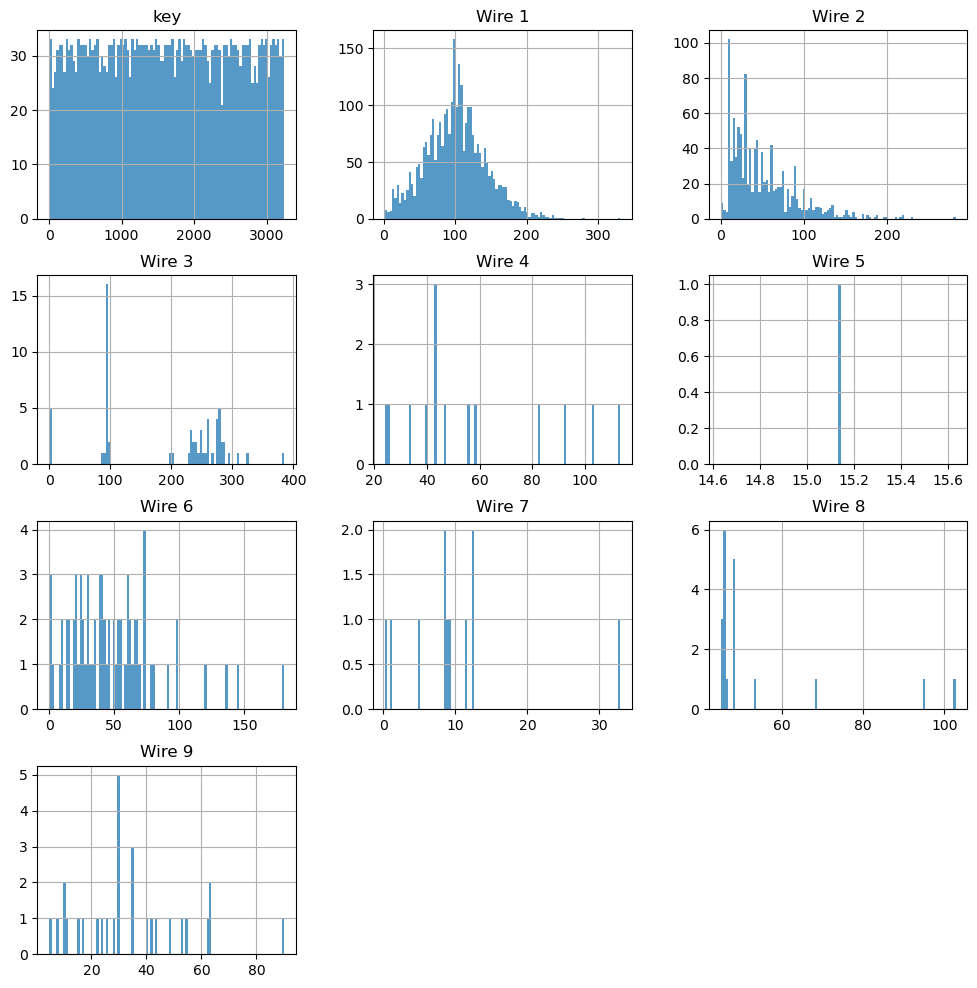

In [22]:
# посмотрим распределение
df_wire.hist(bins=100, legend=False, alpha=0.75,figsize=(12,12));

Выбросы в виде отрицательных значений отсутствуют.

In [23]:
# максимальное количество записей для каждой партии
df_wire['key'].value_counts().max()

1

In [24]:
# информация о времени
df_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Данные о продувке газом

In [25]:
# информация о продувке
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [26]:
# посмотрим характеристики распределения
df_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

In [27]:
# посмотрим датафрейм
df_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


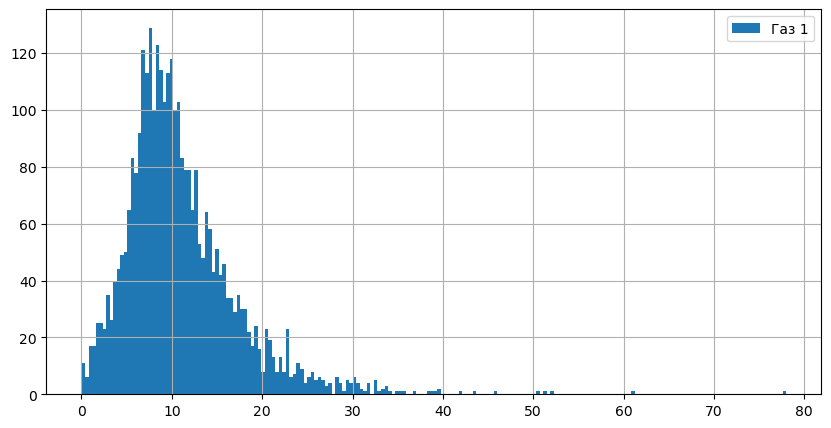

In [28]:
# построим гистограмму
df_gas['Газ 1'].hist(bins=200, legend=True, figsize=(10,5));

In [29]:
# максимальное количество записей для каждой партии
df_gas['Газ 1'].value_counts().max()

1

Каждой партии соотвествует одна запись. Распеделение величины продувки близко к нормальному, предположим, что в столбце "Газ 1" указано количество газа.

#### Данные об измерении температуры

In [30]:
# информация о датафрейме
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [31]:
df_temp.duplicated().sum()

0

Дубликатов нет. Примерно в 3500 случаев отсутсвуют данные о значении температуры.

In [32]:
# определим количество уникальных партий
df_temp['key'].nunique()

3216

In [33]:
df_temp['key'].value_counts()

2108    17
1513    16
1689    16
2567    15
46      14
        ..
247      2
1169     2
246      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

Измерение температуры для разных партий варьируется от 1 до 17 раз.

In [34]:
# посмотрим датафрейм
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [35]:
# характеристики распределения
df_temp['Температура'].describe()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

Диапазон температур соответствует логике бизнес-процесса.

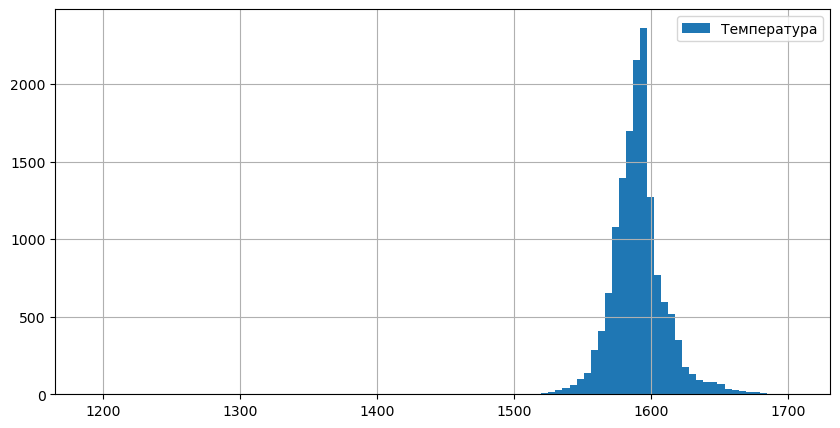

In [36]:
# построим гистограмму
df_temp['Температура'].hist(bins=100, legend=True, figsize=(10,5));

Распределение соответсвтует нормальному, с "выбросом" в районе 1191 градус, однако, это может быть особенностью процесса, удалять ничего не будем.

#### Данные о партиях расплава

При первичном знакомстве с данными было обнаружено не соответствие данных о партиях в различных датасетах. 

Данные об электродах - 3214 уникальных партий.

Данные о засыпке - 3129 уникальных партий.

Данные о продувке - 3239 уникальных партий.

Данные о проволоке  - 3081 уникальных партий.

Данные о температуре - 3216 уникальных партий.

In [37]:
# определим все уникальные номера партий
df_all_key = pd.concat([df_arc['key'], df_bulk['key'], df_bulk_time['key'],
                        df_gas['key'], df_wire['key'], df_wire_time['key'], df_temp['key']]).unique()
print('Уникальных партий расплава: ',df_all_key.shape[0])

Уникальных партий расплава:  3241


In [38]:
# отберем только те партии, которые присутствуют во всех датафреймах
key_list = []
for key in df_all_key:
    if (key in df_arc['key']) and (key in df_bulk['key']) and (key in df_bulk_time['key']) and (key in df_gas['key'])\
    and (key in df_wire['key']) and (key in df_wire_time['key']) and (key in df_temp['key']):
        key_list.append(key)
        
print('Количество партий, присутствующих во всех данных:',len(key_list))

Количество партий, присутствующих во всех данных: 3080


### Вывод по разделу

1. Для исследования были предоставлены данные, содержащиеся в 7 датасетах. Доступна информация о времени и мощности нагрева, данные о легировании сплава крошкой из бункера и с помощью проволоки, данные о продувках газом, данные об измерении температуры.

2. Дубликаты строк в данных отсутствуют.

3. Отмечен выброс в значениях реактивной мощности (отрицательное значение). Распределение активной и реактивной мощности носит нормальный характер со сдвигом вправо. Значения активной мощности (полезная мощность) и реактивной мощности (потери) сопоставими по порядку величины.

4. Данные о трайб-аппаратах и бункерах носят различный характер, гистограммы распределения использованных из них материалов могут иметь как нормальный вид, так и представлять единичные значения. Для неиспользуемых в процессе аппаратов фиксируются пропущенные значения.

5. Значения измеренных температур в целом имеют нормальное распределение со средним значением 1590 градусов и стандартным отклонением 20. Выделяется точка 1191 градус, которая, скорее всего, является особенностью технлогического процесса, а не выбросом.

6. Отмечены несовпадения номеров партий для различных датасетов. Определено, что полная информация представлена только для 3080 партий из 3241 обозначенных.

### План работ

Следует отметить, что данные о подаче материала и данные о продувке являются интегральными, т.е. дана сумма значений по всей партии. Данные по мощности являются дифференциальными, т.е. показаны значения для каждого цикла выплавки партии. Температура расплава зависит от его состава (подача материала), тепловых потерь (обдув газом) и затраченной на нагрев энергии (активная мощность умноженная на время нагрева).

Можно предложить следующий план работы.

1. Подготовка даннных:

- удалить выбросы в мощности, определить интегральное количество энергии, затаченное на нагрев каждой партии;

- провести объединение всех таблиц (кроме мощности) по значению ключа из списка key_list[], добавить в таблицу вычисленную энергию, затраченную на нагрев партии;

- удалить пропуски в целевом признаке (температуре), в остальных признаках (объем проволоки, объем сыпучих материалов, данные о продувке) поставить заглушку (0);

- убрать коррелирующие признаки.

2. Обучение модели:

- для предсказания температуры необходимо решить задачу регрессии, для этого необходимо выбрать метрику для оценки качества, например RMSE. Попробуем несколько классических алгоритмов (регрессия, случайный лес) и градиентный бустинг (lgbm, catboost);

- выбрать модель с лучшим позакателем метрики.

3. Отчет:

- написать подробные выводы по исследованию.

### Вопросы по бизнес-процессу

1. Данные по продувке газом содержат величину расхода или количество газа? В первом случае необходимы времена продувки.

2. Что представляет собой процесс десульфации, какие есть о нем данные? Вынос вещества (серы) из расплава должен сопровождаться потерей энергии и снижением температуры, насколько это критично?

3. Каким образом предсказание температуры стали может повлиять на снижение потребления электроэнергии?

## Предобработка данных

### Время нагрева и работа

In [39]:
# создадим копию датафрейма для расчета интегральной мощности и работы
df_arc_cp = df_arc.copy(deep=True)

# отбросим отрицательные значения реактивной мощности
df_arc_cp = df_arc_cp.loc[df_arc_cp['Реактивная мощность'] > 0]

df_arc_cp

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


In [40]:
# преобразуем данные к датетайм
df_arc_cp['Начало нагрева дугой'] = pd.to_datetime(df_arc_cp['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
df_arc_cp['Конец нагрева дугой'] = pd.to_datetime(df_arc_cp['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [41]:
# вычислим длительность нагрева в секундах
df_arc_cp['Время нагрева'] = df_arc_cp['Конец нагрева дугой'].dt.to_period('s').astype(int) - \
df_arc_cp['Начало нагрева дугой'].dt.to_period('s').astype(int)

df_arc_cp

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57


In [42]:
# определим суммарную мощность для каждого ковша
df_arc_int_power = df_arc_cp.groupby('key')['Активная мощность', 'Реактивная мощность', 
                                           'Время нагрева'].sum()
df_arc_int_power.reset_index(inplace= True)
df_arc_int_power.columns = ['key','Активная мощность', 'Реактивная мощность', 'Время нагрева']

df_arc_int_power

C:\Temp\ipykernel_7868\2759938728.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_arc_int_power = df_arc_cp.groupby('key')['Активная мощность', 'Реактивная мощность',


,key,Активная мощность,Реактивная мощность,Время нагрева
0,1,3.036730,2.142821,1098
1,2,2.139408,1.453357,811
2,3,4.063641,2.937457,655
3,4,2.706489,2.056992,741
4,5,2.252950,1.687991,869
...,...,...,...,...
3209,3237,2.541872,2.025417,909
3210,3238,1.374821,1.038103,546
3211,3239,4.848005,3.541541,1216
3212,3240,3.317679,2.373552,839


In [43]:
# вычислим полную мощность
df_arc_int_power['Полная мощность'] = (df_arc_int_power['Активная мощность']**2 + 
                                       df_arc_int_power['Реактивная мощность']**2 )**0.5

df_arc_int_power

,key,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность
0,1,3.036730,2.142821,1098,3.716640
1,2,2.139408,1.453357,811,2.586371
2,3,4.063641,2.937457,655,5.014163
3,4,2.706489,2.056992,741,3.399456
4,5,2.252950,1.687991,869,2.815155
...,...,...,...,...,...
3209,3237,2.541872,2.025417,909,3.250143
3210,3238,1.374821,1.038103,546,1.722728
3211,3239,4.848005,3.541541,1216,6.003804
3212,3240,3.317679,2.373552,839,4.079307


In [44]:
# вычислим полезную работу
df_arc_int_power['Полезная работа'] = df_arc_int_power['Активная мощность'] * df_arc_int_power['Время нагрева']

df_arc_int_power

,key,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность,Полезная работа
0,1,3.036730,2.142821,1098,3.716640,3334.329540
1,2,2.139408,1.453357,811,2.586371,1735.059888
2,3,4.063641,2.937457,655,5.014163,2661.684855
3,4,2.706489,2.056992,741,3.399456,2005.508349
4,5,2.252950,1.687991,869,2.815155,1957.813550
...,...,...,...,...,...,...
3209,3237,2.541872,2.025417,909,3.250143,2310.561648
3210,3238,1.374821,1.038103,546,1.722728,750.652266
3211,3239,4.848005,3.541541,1216,6.003804,5895.174080
3212,3240,3.317679,2.373552,839,4.079307,2783.532681


### Начальная и конечная температура

In [45]:
# создадим копию датафрейма
df_temp_cp = df_temp.copy(deep=True)
df_temp_cp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [46]:
# определим начальное время замера, берем минимальное значение времени
df_temp_start_time = df_temp_cp.groupby('key').agg({'Время замера': 'min'})
df_temp_start_time.reset_index(inplace= True)
df_temp_start_time.columns = ['key','Время замера']

df_temp_start_time

,key,Время замера
0,1,2019-05-03 11:02:04
1,2,2019-05-03 11:34:04
2,3,2019-05-03 12:06:44
3,4,2019-05-03 12:39:27
4,5,2019-05-03 13:11:03
...,...,...
3211,3237,2019-09-06 11:31:15
3212,3238,2019-09-06 12:16:15
3213,3239,2019-09-06 14:16:50
3214,3240,2019-09-06 15:25:21


In [47]:
# объединим таблицы по совпадению начального времени замера, получим начальную температуру
df_temp_start_time = df_temp_start_time.merge(df_temp_cp, on='Время замера',  how ='inner')

In [48]:
df_temp_start_time

,key_x,Время замера,key_y,Температура
0,1,2019-05-03 11:02:04,1,1571.0
1,2,2019-05-03 11:34:04,2,1581.0
2,3,2019-05-03 12:06:44,3,1596.0
3,4,2019-05-03 12:39:27,4,1601.0
4,5,2019-05-03 13:11:03,5,1576.0
...,...,...,...,...
3211,3237,2019-09-06 11:31:15,3237,1569.0
3212,3238,2019-09-06 12:16:15,3238,1584.0
3213,3239,2019-09-06 14:16:50,3239,1598.0
3214,3240,2019-09-06 15:25:21,3240,1617.0


In [49]:
# определим конечное время замера, берем максимальное значение времени
df_temp_fin_time = df_temp_cp.groupby('key').agg({'Время замера': 'max'})
df_temp_fin_time.reset_index(inplace= True)
df_temp_fin_time.columns = ['key','Время замера']

df_temp_fin_time

,key,Время замера
0,1,2019-05-03 11:30:38
1,2,2019-05-03 11:55:09
2,3,2019-05-03 12:35:57
3,4,2019-05-03 12:59:47
4,5,2019-05-03 13:36:39
...,...,...
3211,3237,2019-09-06 11:55:45
3212,3238,2019-09-06 12:34:37
3213,3239,2019-09-06 15:09:55
3214,3240,2019-09-06 16:35:26


In [50]:
# объединим таблицы по совпадению конечного времени замера, получим конечную температуру
df_temp_fin_time = df_temp_fin_time.merge(df_temp_cp, on='Время замера',  how ='inner')

In [51]:
df_temp_fin_time

,key_x,Время замера,key_y,Температура
0,1,2019-05-03 11:30:38,1,1613.0
1,2,2019-05-03 11:55:09,2,1602.0
2,3,2019-05-03 12:35:57,3,1599.0
3,4,2019-05-03 12:59:47,4,1625.0
4,5,2019-05-03 13:36:39,5,1602.0
...,...,...,...,...
3211,3237,2019-09-06 11:55:45,3237,NaN
3212,3238,2019-09-06 12:34:37,3238,NaN
3213,3239,2019-09-06 15:09:55,3239,NaN
3214,3240,2019-09-06 16:35:26,3240,NaN


In [52]:
# итоговый датафрейм для температуры ковша
df_temp_full = pd.DataFrame()

df_temp_full['key'] = df_temp_fin_time['key_x']
df_temp_full['T начальная'] = df_temp_start_time['Температура']
df_temp_full['T конечная'] = df_temp_fin_time['Температура']

In [53]:
df_temp_full

,key,T начальная,T конечная
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
3211,3237,1569.0,NaN
3212,3238,1584.0,NaN
3213,3239,1598.0,NaN
3214,3240,1617.0,NaN


### Итоговый набор признаков

Объединим все доступные таблицы с признаками в одну, используем пересечение по ключу.

In [54]:
df_full = pd.merge(df_temp_full, df_arc_int_power, on='key', how ='inner')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  3214 non-null   int64  
 1   T начальная          3214 non-null   float64
 2   T конечная           2475 non-null   float64
 3   Активная мощность    3214 non-null   float64
 4   Реактивная мощность  3214 non-null   float64
 5   Время нагрева        3214 non-null   int64  
 6   Полная мощность      3214 non-null   float64
 7   Полезная работа      3214 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 226.0 KB


In [55]:
df_full = df_full.merge(df_gas, on='key', how ='inner')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3212 entries, 0 to 3211
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  3212 non-null   int64  
 1   T начальная          3212 non-null   float64
 2   T конечная           2473 non-null   float64
 3   Активная мощность    3212 non-null   float64
 4   Реактивная мощность  3212 non-null   float64
 5   Время нагрева        3212 non-null   int64  
 6   Полная мощность      3212 non-null   float64
 7   Полезная работа      3212 non-null   float64
 8   Газ 1                3212 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 250.9 KB


In [56]:
df_full = df_full.merge(df_wire, on='key', how ='inner')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3078 entries, 0 to 3077
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  3078 non-null   int64  
 1   T начальная          3078 non-null   float64
 2   T конечная           2370 non-null   float64
 3   Активная мощность    3078 non-null   float64
 4   Реактивная мощность  3078 non-null   float64
 5   Время нагрева        3078 non-null   int64  
 6   Полная мощность      3078 non-null   float64
 7   Полезная работа      3078 non-null   float64
 8   Газ 1                3078 non-null   float64
 9   Wire 1               3052 non-null   float64
 10  Wire 2               1079 non-null   float64
 11  Wire 3               63 non-null     float64
 12  Wire 4               14 non-null     float64
 13  Wire 5               1 non-null      float64
 14  Wire 6               73 non-null     float64
 15  Wire 7               11 non-null     f

In [57]:
df_full = df_full.merge(df_bulk, on='key', how ='inner')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3022 entries, 0 to 3021
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  3022 non-null   int64  
 1   T начальная          3022 non-null   float64
 2   T конечная           2329 non-null   float64
 3   Активная мощность    3022 non-null   float64
 4   Реактивная мощность  3022 non-null   float64
 5   Время нагрева        3022 non-null   int64  
 6   Полная мощность      3022 non-null   float64
 7   Полезная работа      3022 non-null   float64
 8   Газ 1                3022 non-null   float64
 9   Wire 1               2997 non-null   float64
 10  Wire 2               1051 non-null   float64
 11  Wire 3               63 non-null     float64
 12  Wire 4               14 non-null     float64
 13  Wire 5               1 non-null      float64
 14  Wire 6               73 non-null     float64
 15  Wire 7               11 non-null     f

### Обработка пропусков и выбросов

In [58]:
# определим количество пропусков
df_full.isna().sum()

key                       0
T начальная               0
T конечная              693
Активная мощность         0
Реактивная мощность       0
Время нагрева             0
Полная мощность           0
Полезная работа           0
Газ 1                     0
Wire 1                   25
Wire 2                 1971
Wire 3                 2959
Wire 4                 3008
Wire 5                 3021
Wire 6                 2949
Wire 7                 3011
Wire 8                 3003
Wire 9                 2997
Bulk 1                 2770
Bulk 2                 3000
Bulk 3                 1729
Bulk 4                 2010
Bulk 5                 2945
Bulk 6                 2452
Bulk 7                 2998
Bulk 8                 3021
Bulk 9                 3003
Bulk 10                2846
Bulk 11                2845
Bulk 12                 666
Bulk 13                3004
Bulk 14                 313
Bulk 15                 788
dtype: int64

Целевым признаком является конечная температура ковша, удалим строки с пропусками в целевом признаке.

In [59]:
# удалим объекты без целевого признака
df_full = df_full.dropna(subset=['T конечная'])
df_full.isna().sum()

key                       0
T начальная               0
T конечная                0
Активная мощность         0
Реактивная мощность       0
Время нагрева             0
Полная мощность           0
Полезная работа           0
Газ 1                     0
Wire 1                   23
Wire 2                 1518
Wire 3                 2290
Wire 4                 2317
Wire 5                 2329
Wire 6                 2284
Wire 7                 2325
Wire 8                 2316
Wire 9                 2305
Bulk 1                 2130
Bulk 2                 2316
Bulk 3                 1369
Bulk 4                 1517
Bulk 5                 2276
Bulk 6                 1891
Bulk 7                 2316
Bulk 8                 2328
Bulk 9                 2316
Bulk 10                2186
Bulk 11                2199
Bulk 12                 517
Bulk 13                2315
Bulk 14                 261
Bulk 15                 630
dtype: int64

In [60]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2329 non-null   int64  
 1   T начальная          2329 non-null   float64
 2   T конечная           2329 non-null   float64
 3   Активная мощность    2329 non-null   float64
 4   Реактивная мощность  2329 non-null   float64
 5   Время нагрева        2329 non-null   int64  
 6   Полная мощность      2329 non-null   float64
 7   Полезная работа      2329 non-null   float64
 8   Газ 1                2329 non-null   float64
 9   Wire 1               2306 non-null   float64
 10  Wire 2               811 non-null    float64
 11  Wire 3               39 non-null     float64
 12  Wire 4               12 non-null     float64
 13  Wire 5               0 non-null      float64
 14  Wire 6               45 non-null     float64
 15  Wire 7               4 non-null      f

In [61]:
# удалим столбцы с большим количеством пропусков и столбец key
df_full.drop(columns = ['Wire 3',
                        'Wire 4',
                        'Wire 5',
                        'Wire 6',
                        'Wire 7',
                        'Wire 8',
                        'Wire 9',
                        'Bulk 2',
                        'Bulk 5',
                        'Bulk 7',
                        'Bulk 8',
                        'Bulk 9',
                        'Bulk 13',
                        'key'],
             axis = 1, inplace=True)

С учетом пункта 1.1.5, отбросим строки с температурой меньше 1450 градусов.

In [62]:
df_full = df_full.loc[df_full['T начальная'] >= 1450]

In [63]:
# заполним пропуски нолями
df_full = df_full.fillna(0)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2328
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   T начальная          2325 non-null   float64
 1   T конечная           2325 non-null   float64
 2   Активная мощность    2325 non-null   float64
 3   Реактивная мощность  2325 non-null   float64
 4   Время нагрева        2325 non-null   int64  
 5   Полная мощность      2325 non-null   float64
 6   Полезная работа      2325 non-null   float64
 7   Газ 1                2325 non-null   float64
 8   Wire 1               2325 non-null   float64
 9   Wire 2               2325 non-null   float64
 10  Bulk 1               2325 non-null   float64
 11  Bulk 3               2325 non-null   float64
 12  Bulk 4               2325 non-null   float64
 13  Bulk 6               2325 non-null   float64
 14  Bulk 10              2325 non-null   float64
 15  Bulk 11              2325 non-null   f

In [64]:
df_full

,T начальная,T конечная,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность,Полезная работа,Газ 1,Wire 1,Wire 2,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1571.0,1613.0,3.036730,2.142821,1098,3.716640,3334.329540,29.749986,60.059998,0.00000,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0
1,1581.0,1602.0,2.139408,1.453357,811,2.586371,1735.059888,12.555561,96.052315,0.00000,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0
2,1596.0,1599.0,4.063641,2.937457,655,5.014163,2661.684855,28.554793,91.160157,0.00000,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0
3,1601.0,1625.0,2.706489,2.056992,741,3.399456,2005.508349,18.841219,89.063515,0.00000,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0
4,1576.0,1602.0,2.252950,1.687991,869,2.815155,1957.813550,5.413692,89.238236,9.11456,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1570.0,1591.0,3.168133,2.210936,723,3.863328,2290.560159,7.125735,89.150879,0.00000,0.0,21.0,0.0,0.0,90.0,0.0,256.0,129.0,223.0
2325,1554.0,1591.0,4.174918,2.872031,940,5.067396,3924.422920,9.412616,114.179527,0.00000,0.0,0.0,63.0,0.0,122.0,0.0,256.0,129.0,226.0
2326,1571.0,1589.0,3.605239,2.452092,569,4.360104,2051.380991,6.271699,94.086723,9.04800,0.0,0.0,85.0,0.0,0.0,0.0,230.0,124.0,226.0
2327,1591.0,1594.0,3.202310,2.239820,750,3.907887,2401.732500,14.953657,118.110717,0.00000,0.0,90.0,0.0,0.0,101.0,0.0,206.0,129.0,207.0


### Проверка мультиколлиниарности

In [65]:
df_full.corr().style.background_gradient(cmap='coolwarm')

,T начальная,T конечная,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность,Полезная работа,Газ 1,Wire 1,Wire 2,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
T начальная,1.000000,0.301961,-0.153133,-0.151167,-0.383545,-0.152710,-0.205640,0.036730,0.262946,-0.101012,0.079137,-0.113271,0.165562,-0.127241,0.035824,-0.110397,-0.079339,-0.180058,-0.062137
T конечная,0.301961,1.000000,0.176956,0.171494,0.278558,0.175334,0.215693,0.059036,0.317702,-0.206837,-0.075233,-0.036767,0.188100,-0.181880,0.061345,-0.114777,0.267379,0.114520,0.266386
Активная мощность,-0.153133,0.176956,1.000000,0.992416,0.720854,0.999049,0.844956,0.370806,0.137943,0.062619,0.099239,0.101503,0.005279,0.132842,0.010380,0.065874,0.285545,0.299350,0.169072
Реактивная мощность,-0.151167,0.171494,0.992416,1.000000,0.713082,0.996832,0.835938,0.367789,0.138346,0.062023,0.095763,0.099230,0.004375,0.132113,0.008528,0.064092,0.285217,0.295340,0.167399
Время нагрева,-0.383545,0.278558,0.720854,0.713082,1.000000,0.719320,0.874650,0.396016,0.055796,0.054753,0.102831,0.091940,-0.028682,0.161305,-0.005277,0.078040,0.466434,0.460475,0.295149
Полная мощность,-0.152710,0.175334,0.999049,0.996832,0.719320,1.000000,0.843209,0.370360,0.138322,0.062510,0.098149,0.100881,0.004956,0.132780,0.009724,0.065362,0.285913,0.298432,0.168761
Полезная работа,-0.205640,0.215693,0.844956,0.835938,0.874650,0.843209,1.000000,0.402776,0.085225,0.059747,0.121452,0.082057,-0.022833,0.175018,0.000878,0.066996,0.358829,0.352370,0.196901
Газ 1,0.036730,0.059036,0.370806,0.367789,0.396016,0.370360,0.402776,1.000000,0.118173,0.104639,0.234081,0.059651,0.017521,0.139475,-0.008637,0.041942,0.216869,0.268275,0.042995
Wire 1,0.262946,0.317702,0.137943,0.138346,0.055796,0.138322,0.085225,0.118173,1.000000,-0.069288,0.013896,0.037950,0.298265,-0.235764,0.062951,-0.117736,0.171090,-0.052792,0.119366
Wire 2,-0.101012,-0.206837,0.062619,0.062023,0.054753,0.062510,0.059747,0.104639,-0.069288,1.000000,-0.009198,0.095025,-0.267932,0.204771,-0.103766,0.062112,-0.097866,0.036891,-0.096044


Наблюдается корреляция признаков, связанных с мощностью. Признаков, коррелирующих с целевым не наблюдается. Очевидно, что полная мощность сильно коррелирует с активной и реактивной, а они друг с другом. Интересно, что полезная работа, которая получается более простым преобразованием, имеет меньшую корреляцию. Удалим полную и реактивную мощность из датасета.

In [66]:
df_full = df_full.drop(columns = ['Реактивная мощность',
                                 'Полная мощность'],
                       axis=1)

In [67]:
df_full

,T начальная,T конечная,Активная мощность,Время нагрева,Полезная работа,Газ 1,Wire 1,Wire 2,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1571.0,1613.0,3.036730,1098,3334.329540,29.749986,60.059998,0.00000,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0
1,1581.0,1602.0,2.139408,811,1735.059888,12.555561,96.052315,0.00000,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0
2,1596.0,1599.0,4.063641,655,2661.684855,28.554793,91.160157,0.00000,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0
3,1601.0,1625.0,2.706489,741,2005.508349,18.841219,89.063515,0.00000,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0
4,1576.0,1602.0,2.252950,869,1957.813550,5.413692,89.238236,9.11456,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1570.0,1591.0,3.168133,723,2290.560159,7.125735,89.150879,0.00000,0.0,21.0,0.0,0.0,90.0,0.0,256.0,129.0,223.0
2325,1554.0,1591.0,4.174918,940,3924.422920,9.412616,114.179527,0.00000,0.0,0.0,63.0,0.0,122.0,0.0,256.0,129.0,226.0
2326,1571.0,1589.0,3.605239,569,2051.380991,6.271699,94.086723,9.04800,0.0,0.0,85.0,0.0,0.0,0.0,230.0,124.0,226.0
2327,1591.0,1594.0,3.202310,750,2401.732500,14.953657,118.110717,0.00000,0.0,90.0,0.0,0.0,101.0,0.0,206.0,129.0,207.0


In [68]:
df_full.corr().style.background_gradient(cmap='coolwarm')

,T начальная,T конечная,Активная мощность,Время нагрева,Полезная работа,Газ 1,Wire 1,Wire 2,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
T начальная,1.000000,0.301961,-0.153133,-0.383545,-0.205640,0.036730,0.262946,-0.101012,0.079137,-0.113271,0.165562,-0.127241,0.035824,-0.110397,-0.079339,-0.180058,-0.062137
T конечная,0.301961,1.000000,0.176956,0.278558,0.215693,0.059036,0.317702,-0.206837,-0.075233,-0.036767,0.188100,-0.181880,0.061345,-0.114777,0.267379,0.114520,0.266386
Активная мощность,-0.153133,0.176956,1.000000,0.720854,0.844956,0.370806,0.137943,0.062619,0.099239,0.101503,0.005279,0.132842,0.010380,0.065874,0.285545,0.299350,0.169072
Время нагрева,-0.383545,0.278558,0.720854,1.000000,0.874650,0.396016,0.055796,0.054753,0.102831,0.091940,-0.028682,0.161305,-0.005277,0.078040,0.466434,0.460475,0.295149
Полезная работа,-0.205640,0.215693,0.844956,0.874650,1.000000,0.402776,0.085225,0.059747,0.121452,0.082057,-0.022833,0.175018,0.000878,0.066996,0.358829,0.352370,0.196901
Газ 1,0.036730,0.059036,0.370806,0.396016,0.402776,1.000000,0.118173,0.104639,0.234081,0.059651,0.017521,0.139475,-0.008637,0.041942,0.216869,0.268275,0.042995
Wire 1,0.262946,0.317702,0.137943,0.055796,0.085225,0.118173,1.000000,-0.069288,0.013896,0.037950,0.298265,-0.235764,0.062951,-0.117736,0.171090,-0.052792,0.119366
Wire 2,-0.101012,-0.206837,0.062619,0.054753,0.059747,0.104639,-0.069288,1.000000,-0.009198,0.095025,-0.267932,0.204771,-0.103766,0.062112,-0.097866,0.036891,-0.096044
Bulk 1,0.079137,-0.075233,0.099239,0.102831,0.121452,0.234081,0.013896,-0.009198,1.000000,-0.011462,0.041733,-0.003822,-0.023304,-0.037985,0.325753,0.207525,-0.001041
Bulk 3,-0.113271,-0.036767,0.101503,0.091940,0.082057,0.059651,0.037950,0.095025,-0.011462,1.000000,-0.295303,0.065696,-0.085192,-0.007331,0.018409,0.011061,-0.012791


### Подготовка тестовой и обучающей выборок

In [69]:
# зафиксируем рандом стайт
ran_st = 170723

In [70]:
#выделим из данных валидационную выборку
df_train, df_test = train_test_split(df_full, test_size=0.25, random_state = ran_st)

In [71]:
#выделим признаки и целевой признак во всех выборках
features_train = df_train.drop(['T конечная'], axis=1)
target_train = df_train['T конечная']
features_test = df_test.drop(['T конечная'], axis=1)
target_test = df_test['T конечная']

## Модели обучения

### LGBM

In [72]:
# создадим модель
lgbm_model = LGBMRegressor(random_state=ran_st)

In [73]:
# определим параметры, которые будем подбирать
parameters = {'n_estimators': range(54,56), 'num_leaves': range(16,19), 'max_depth': range(6,8)}

In [74]:
#определим параметры обучения, 5 группы для кросс-валидации
grid_search_model_lgbm = GridSearchCV(lgbm_model, parameters, cv=5, n_jobs=-1, scoring = 'neg_mean_absolute_error')

In [75]:
#проведем кросс-валидацию
grid_search_model_lgbm.fit(features_train, target_train)

# выберем лучшую модель
best_model_lgbm = (grid_search_model_lgbm.best_estimator_)

# лучшие параметры
print('Наилучшие параметры:', grid_search_model_lgbm.best_params_)

Наилучшие параметры: {'max_depth': 7, 'n_estimators': 54, 'num_leaves': 18}


In [76]:
lgbm_mae = round(-grid_search_model_lgbm.best_score_, 2)
print('LGBM, наилучшee MAE:', lgbm_mae)

LGBM, наилучшee MAE: 6.28


### RandomForestRegressor

In [77]:
# создадим модель случайного леса
model_forest = RandomForestRegressor(random_state=ran_st)

In [78]:
# определим параметры модели, которые будем подбирать
parameters = {'max_depth': range(10,12), 'n_estimators': range(270, 290, 10)}

In [79]:
#определим параметры обучения, 5 групп кросс-валидации, в качестве метрики будем использовать MAE
grid_search_model_forest = GridSearchCV(model_forest, parameters, cv=5, n_jobs=-1, scoring = 'neg_mean_absolute_error')

In [80]:
#проведем кросс-валидацию
grid_search_model_forest.fit(features_train, target_train)

# выберем лучшую модель
best_model_forest = (grid_search_model_forest.best_estimator_)

# лучшие параметры
print('Наилучшие параметры:', grid_search_model_forest.best_params_)

Наилучшие параметры: {'max_depth': 10, 'n_estimators': 280}


In [81]:
forest_mae = round(-grid_search_model_forest.best_score_, 2)
print('RandomForestRegressor, наилучшee MAE:', forest_mae)

RandomForestRegressor, наилучшee MAE: 6.39


### Линейная регрессия

In [82]:
# модель линейной регрессии
model_lr = LinearRegression()

#parametrs = {'normalize': [True, False]}

#grid_search_model_lr = GridSearchCV(model_lr, parametrs, cv=5, scoring='neg_mean_absolute_error')

# обучение модели
#grid_search_model_lr.fit(features_train, target_train)

# выберем лучшую модель
#best_model_lr = (grid_search_model_lr.best_estimator_)

# лучшие параметры
#print('Наилучшие параметры:', grid_search_model_lr.best_params_)

scores = -cross_val_score(model_lr, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')

print('MAE линейной регрессии:', round(sum(scores)/len(scores),2))

MAE линейной регрессии: 6.42


### Проверка лучшей модели

In [84]:
# выполним предсказания
lgbm_pred = best_model_lgbm.predict(features_test)

In [85]:
# посчитаем метрику
lgbm_mae = round(mean_absolute_error(target_test, lgbm_pred),2)
print('LGBM MAE на тестовой выборке', lgbm_mae)

LGBM MAE на тестовой выборке 6.03


### Анализ важности факторов

In [86]:
def importances(model,features):
    features = features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Влияние признаков на предсказания модели')
    plt.barh(range(len(indices)), importances[indices], color='green', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность признаков')
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Относительная важность признаков']
    display(feat_importances)

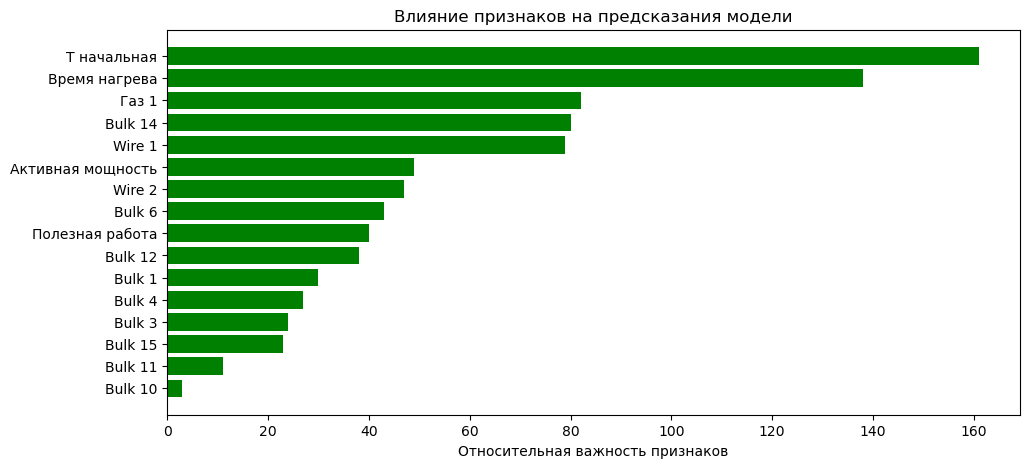

,Относительная важность признаков
T начальная,161
Время нагрева,138
Газ 1,82
Bulk 14,80
Wire 1,79
Активная мощность,49
Wire 2,47
Bulk 6,43
Полезная работа,40
Bulk 12,38


In [87]:
# данные по важности
importances(best_model_lgbm, features_test)

Интересно, что для модели активная мощность не так важна, по большому счету, она ее везде воспринимает примерно одинаковой. А вот время нагрева и количество газа изменяются сильнее, и сильнее сказываются на результате.

## Отчет

### Ответы на вопросы

1. Были выполнены все пункты плана. Получены вторичные признаки в виде полной мощности и полезной работы, удалены выбросы в значениях реактивной мощности и температуры. Проведено объединение таблиц по ключу, получены значения начальной и конечной температуры ковша. Удалены пропуски в целевом признаке (конечная температура ковша), пропуски в остальных признаках заполнены нолями. Удалены коррелирующие признаки (полная и реактивная мощность) и признаки с малым количеством значений. Проверены три модели обучения, выбрана лучшая (lgbm), которая показала на тестовой выборке значение MAE 6.03.

2. Основной трудностью было сформировать конечный датафрейм, содержащий целевой и остальные признаки. Необходимо было объединить таблицы по ключу, и, что самое важное, получить начальную и конечную температуры из данных об измерениях. 

3. Можно выделить следующие ключевые шаги в решении задачи:

- понимание бизнес-процесса, это ключевой шаг, на основе результатов которого строится все решение. Например, было необходимо понять, что это задача не о временных рядах и времена измерений для моделей не нужны, они нужны только для формирования обучающей и тестовой выборки;

- формирование коненчного набора данных со всеми признаками, его предобработка;

- проверка различных моделей, выбор лучшей.

4. По результатам исследования выбрана модель LGBM, которая показала на тестовой выборке значение MAE, равное 6.03.

### Список признаков

В итоговый набор данных вошли следующие признаки: T начальная, T конечная (целевой признак), Активная мощность, Время нагрева, Полезная работа (вторичный признак, полученный с помощью вычисления), Газ 1 и данные о контейнерах и трайб-аппаратах. На этапе предобработки удалены объекты с начальной температурой меньше 1450 градусов, объекты с пропусками в целевом признаке, а также данные о контейнерах и трайб-аппаратах, содержащие малое количество значений.

### Лучшая модель

Параметры лучшей модели LGBM следующие: {'max_depth': 7, 'n_estimators': 54, 'num_leaves': 18}, random_state = 170723. Значение MAE на обучающей выборке составило 6.28, на тестовой выборке 6.03.

### Рекомендации

Нужно выделить два аспекта решения задачи. Первый аспект - создание модели предсказания с лучшей метрикой. В данном аспекте, на мой взгляд, улучшать нечего. Средняя абсолютная разница между реальным и предсказанным значением составляет 6 градусов, это 0.4 % от измеряемой величины, с учетом того, что реальная температура измеряется, в лучшем случае, с погрешностью ±1° С (погрешность термопар, а еще есть градиент температуры по ковшу (кстати какой он?), погрешность измерительного канала, погрешность методики измерений и т.д.), то улучшение метрики не имеет смысла. На мой взгляд, для бизнеса измерение с точностью ± 10°С будет приемлемым.

Второй аспект - что требуется сделать для сокращения расходов бизнеса. Для бизнеса важна температура не сама по себе, а ее стабильность, если температура выше чем нужно, значит потратили лишнюю энергию на прогрев всех конструкций и окружающего пространства, если она ниже чем нужно, значит лишнюю энергию предстоит потратить. В этом случае необходимо обратить внимание на факторы, больше всего влияющие на значения конечной температуры: начальная температура, время нагрева, продувка газом. По времени нагрева нужно отметить следующее, оно важно для модели, но не для бизнеса, т.к. в реальности оно будет таким, какое требуется. Если провал по температуре будет большой, то и время будет большим, и наоборот. На стабильность влияют начальная температура и продувка газом.

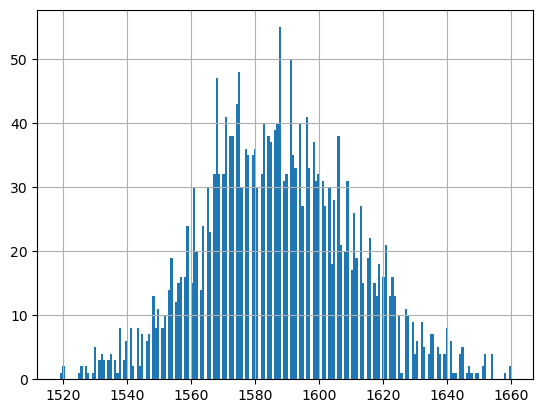

In [95]:
# посмотрим внимательно на данные о начальной температуре и продувке.
df_full['T начальная'].hist(bins=200);

In [96]:
df_full['T начальная'].describe()

count    2325.000000
mean     1587.365161
std        23.623144
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: T начальная, dtype: float64

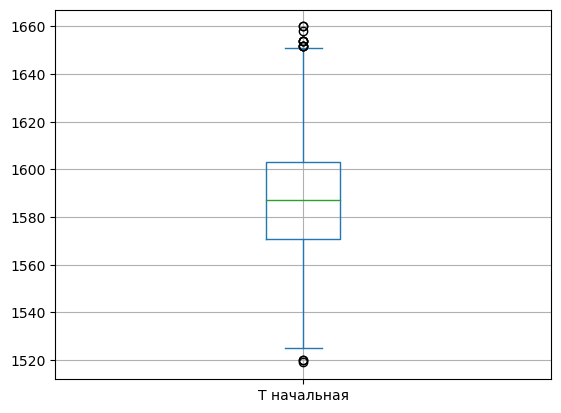

In [100]:
df_full['T начальная'].plot.box(grid=True);

Видны выбросы выше 1650 и ниже 1530.

In [131]:
# посмотрим занижение температуры
df_temp_low = df_temp_start_time[(df_temp_start_time['Температура'] < 1530)]
df_temp_low

,key_x,Время замера,key_y,Температура
85,88,2019-05-06 17:48:51,88,1526.0
506,512,2019-05-23 02:49:33,512,1520.0
540,548,2019-05-24 09:48:02,548,1529.0
855,867,2019-06-06 08:03:39,867,1191.0
896,908,2019-06-07 14:32:37,908,1520.0
1201,1214,2019-06-18 08:01:03,1214,1208.0
1386,1400,2019-06-25 04:37:55,1400,1527.0
1488,1503,2019-06-28 22:07:29,1503,1525.0
1604,1619,2019-07-03 02:34:41,1619,1218.0
1656,1671,2019-07-04 17:02:03,1671,1519.0


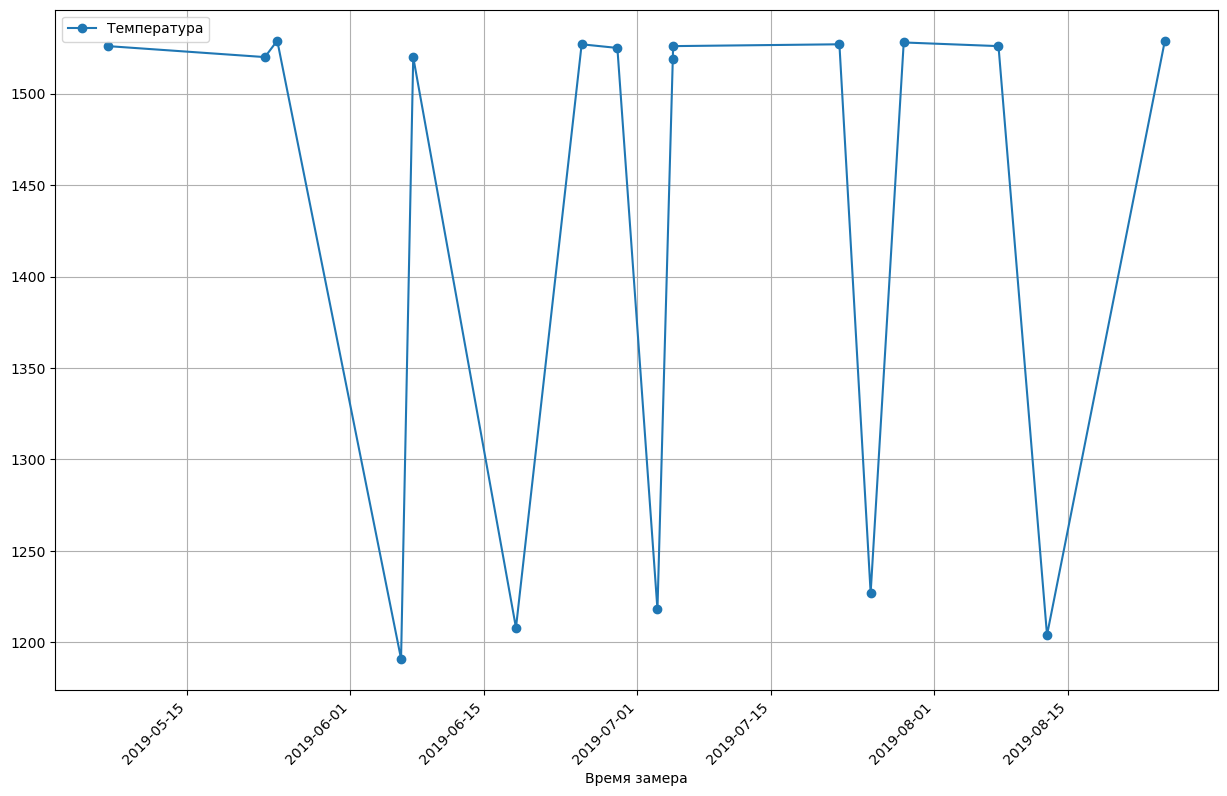

In [126]:
df_temp_low.plot(x='Время замера',
                  y = 'Температура',
                  style='o-',
                  figsize=(15,10),
                  grid=True)
plt.xticks(rotation=45);

Интересно, что из 5 самых низких значений (около 1200°), три значения фиксировались в районе 8-9 утра, одно в 2-30 и одно в районе 19. Возможно, это связано с началом и концом рабочей смены (пересменка ведет к остыванию ковша).

Итого. Поиск причин нестабильности нужно начать с анализа бизнес-процессов компании и технологии.